In [ ]:
import numpy as np
from pylab import *
from PIL import Image
from PIL import ImageDraw
import numpy as np
from matplotlib import cm

def CrossChekExp(im1,im2,c1,c2,b1,b2,ang1,ang2,rots):
  ind,o_ind=Lowes(b1,b2)
  ang1=ang1[o_ind]
  res=np.zeros((max(im1.shape[0],im2.shape[0]),im1.shape[1]+im2.shape[1],3),np.uint8)
  res[:im1.shape[0],:im1.shape[1],0]=im1
  res[:im1.shape[0],:im1.shape[1],1]=im1
  res[:im1.shape[0],:im1.shape[1],2]=im1
  res[:im2.shape[0],im1.shape[1]:,0]=im2
  res[:im2.shape[0],im1.shape[1]:,1]=im2
  res[:im2.shape[0],im1.shape[1]:,2]=im2
  r=Image.fromarray(res)
  d = ImageDraw.Draw(r)
  randc = lambda: int(np.random.randint(1,255))
  xmean=0
  xstd=0
  ymean=0
  ystd=0
  x=[]
  y=[]
  for i in range(len(ind)):
    i2=ind[i][1]
    o=ind[i][2]
    if o==o_ind:
      x.append(c2[i2][0])
      y.append(c2[i2][1])
  x=np.array(x)
  y=np.array(y)
  xmean=np.mean(x)
  ymean=np.mean(y)
  xstd=np.std(x)
  ystd=np.std(y)
  k=1.5
  smn=0.4
  smx=2.0
  step=0.1
  parts=int(np.round((smx-smn)/(step)))
  scales=np.linspace(smn,smx,parts+1)
  scales=scales[:-1]
  w,h=im1.shape[:2]
  cm=np.zeros((rots.shape[0],scales.shape[0],w,h))#массив для преобразований Хафа
  for i in range(len(ind)):
    i1=ind[i][0]
    i2=ind[i][1]
    o=ind[i][2]+1
    if (o-1)==o_ind:
      x1=c1[o-1][i1][0]
      x2=c2[i2][0]
      y1=c1[o-1][i1][1]
      y2=c2[i2][1]
      if abs(c2[i2][0]-xmean)<xstd*k and abs(c2[i2][1]-ymean)<ystd*k  :# фильтрация выбросов
        d.line([(y1*o,x1*o),(y2+im1.shape[1],x2)], fill=(randc(),randc(),randc()), width=2)
        an1=ang1[x1,y1]
        an2=ang2[x2,y2]
        i_rot=rounder(rots)(an2-an1)
        for s in range(scales.shape[0]):
          cx=int(np.round(x1*o*scales[s]))
          cy=int(np.round(y1*o*scales[s]))
          cm[i_rot,s,x2-cx,y2-cy]+=1
  ind = np.unravel_index(np.argmax(cm), cm.shape)
  return r,cm
def Lowes(b1,b2,R=0.75):#b1-query[] массив b2-test
  curhd1=None
  curhd2=None
  min=-1
  resind=[]
  count_o=np.zeros((len(b1)))
  for o in range(len(b1)):
    for i in range(len(b1[o])):
      min=HemmingD(b1[o][i],b2[0])
      curd1=0
      curd2=0
      r=HemmingD(b1[o][i],b2[0])
      for j in range(len(b2)):
        r=HemmingD(b1[o][i],b2[j])
        if r<min:
          min=r
          curd2=curd1
          curd1=j
      
      if HemmingD(b1[o][i],b2[curd1])/HemmingD(b1[o][i],b2[curd2])<R:
        count_o[o]+=1
        resind.append([i,curd1,o])#o-октава
        print(HemmingD(b1[o][i],b2[curd1]),"/",HemmingD(b1[o][i],b2[curd2]),":",HemmingD(b1[o][i],b2[curd1])/HemmingD(b1[o][i],b2[curd2]))
        #print(curd1,"/",curd2)
  o_ind=np.argmax(count_o,axis=0)
  print('octave:',o_ind)
  #if np.sum(res[:,:,0])
  return resind,o_ind
 #---------- 
def HemmingD(b1,b2):
  r=0
  for i in range(len(b1)):
    if b1[i]!=b2[i]:
      r+=1
  return r 
 #---------- 
def PCheck(r1,r2):
  r=np.zeros((r1.shape))
  for x in range(r1.shape[0]):
    for y in range(r1.shape[1]):
      if r1[x,y]!=0:
        if r2[x//2,y//2]!=0:
          r=[x,y]=255
  return r
 #---------- 
def ImgD(img):
  img=img.copy()
  if img.shape[0]%2==1:
    img=img[:-1,:]
  if img.shape[1]%2==1:
    img=img[:,:-1]
  img=((img[::2,::2]+img[1::2,1::2]+img[1::2,::2]+img[::2,1::2])/4)
  return img
 #---------- 
def BRIEF(img,p,ang,coords=None,angles=None,flag=True,shift=15):
  if flag:
    coords,angles=PrepC(shift)
  im=np.zeros((img.shape),dtype=np.int)
  im[:,:]=img[:,:]
  bins=[]
  dc=[]
  for x in range(p.shape[0]):
    for y in range(p.shape[1]):
      if p[x,y]!=0:
        dc.append([x,y])
        ind=rounder(angles)(ang[x,y])
        #print(f'{angles[ind]}/{ang[x,y]}')
        bin=Describe(im,x,y,coords[ind].copy())
        bins.append(bin)
  return np.array(bins,dtype=np.bool),coords,angles,np.array(dc,dtype=np.int)
 #---------- 
def PrepC(shift=30,count=256,parts=60):
  an=np.linspace(-np.pi,np.pi,parts+1)
  an=an[:-1]
  #si=(31**2)/200#31**(2/25)#(31**2)/25
  si=np.sqrt((31**2)/25)
  coords=np.zeros((count,2,2),dtype=np.int)
  coords=np.round(np.random.normal(0,si,(count,2,2)))#np.random.randint(-shift,shift+1,(count,2,2))
  clipper=round(shift/np.sqrt(2))
  #coords=np.clip(coords,-clipper,clipper)
  r=shift**2
  for i in range(count):
    for j in range(2):
      if coords[i,j,0]**2+coords[i,j,1]**2>r:
        coords[i,j]=np.clip(coords[i,j],-clipper,clipper)
  c=np.zeros((parts,count,2,2),dtype=np.int)
  for i in range(len(an)):
    rot=RotMB(an[i])
    c[i,:,0,:]=np.round((rot@coords[:,0,:].T).T)
    c[i,:,1,:]=np.round((rot@coords[:,1,:].T).T)
  return c,an
def Describe(img,x,y,coords,count=256,shift=1):
  w,h=img.shape[0],img.shape[1]
  gm=GetGM()
  bin=np.zeros((count),dtype=np.bool)
  coords[:,:,0]+=x
  coords[:,:,1]+=y
  for i in range(coords.shape[0]):
    cx1=coords[i,0,0]
    cy1=coords[i,0,1]
    cx2=coords[i,1,0]
    cy2=coords[i,1,1]
    if img[cx1,cy1]<img[cx2,cy2]:
      bin[i]=1
    else:
      bin[i]=0
  return bin#,coords
def RotM(teta):
  cos=np.cos(teta)
  sin=np.sin(teta)
  M=np.zeros((2,2))
  M[0,0]=cos
  M[1,0]=-sin
  M[0,1]=sin
  M[1,1]=cos
  return M
def RotMB(teta):
  cos=np.cos(teta)
  sin=np.sin(teta)
  M=np.zeros((2,2))
  M[0,0]=cos
  M[1,0]=sin
  M[0,1]=-sin
  M[1,1]=cos
  return M
def FAST(img,t=20,r=3,l=3):
  k=r*2+1
  fmsk=GetFChek(r)
  msk=GetRM(r)
  ord=CircOrd3()
  img2=img.copy()#
  img=np.zeros((img.shape),dtype=np.int)
  img[:]=img2[:]#
  gM=GetGM(l)
  unigue=np.zeros((img.shape),dtype=np.bool)
  for x in range(r,img.shape[0]-r-1):
    for y in range(r,img.shape[1]-r-1):
      if np.sum((img[x-r:x+r+1,y-r:y+r+1][fmsk]-img[x,y])>t)>2 or np.sum((img[x-r:x+r+1,y-r:y+r+1][fmsk]-img[x,y])<-t)>2:
        if ChekNOrd(ord,img[x-r:x+r+1,y-r:y+r+1],img[x,y],t):

          unigue[x,y]=1
          '''if(x<200 and y>400):
            print(f'x:{x} y:{y}')
            print(img[x-r:x+r+1,y-r:y+r+1])'''
  return unigue 

def Ang(img,p,rmax=31):
  w,h=img.shape[0],img.shape[1]
  ang=np.zeros((img.shape))
  r=rmax**2
  for x in range(w):
    for y in range(h):
      if p[x,y]>0:
        #print(x,"/",y)
        #r=min([rmax,y,h-y,x,w-x])
        #if r<5:
        #  continue
        x1=max(0,x-rmax)
        x2=min(w,x+rmax)
        y1=max(0,y-rmax)
        y2=min(h,y+rmax)

        m01=0
        m10=0

        for i in range(x1,x2):
          for j in range(y1,y2):
            cx=i-x
            cy=j-y
            if cx**2+cy**2<=r:
              m01+=(cy*img[i,j])
              m10+=(cx*img[i,j])
        ang[x,y]=np.arctan2(m01,m10)
  return ang
def Xarris(img,p,k=0.06,N=100,shift=31,si=0.8):
  Mdx,Mdy=DMxy(img)
  Mdx,Mdy=np.abs(Mdx),np.abs(Mdy)
  win_size=5
  step=win_size//2
  gm=GetGM(size=win_size,sigma=0.6)
  A=np.zeros((2,2))
  R=np.zeros((img.shape))
  for x in range(shift,img.shape[0]-shift):
    for y in range(shift,img.shape[1]-shift):
      if p[x,y]==1 :#and und[x//2,y//2]==1:#
        dx=gm*Mdx[x-step:x+step+1,y-step:y+step+1]#Mdx[x,y]
        dy=gm*Mdy[x-step:x+step+1,y-step:y+step+1]#Mdy[x,y]
        A[0,0]=np.sum(dx*dx)#dx**2
        A[1,0]=np.sum(dx*dy)#dx*dy
        A[0,1]=np.sum(dx*dy)#dx*dy
        A[1,1]=np.sum(dy*dy)#dy**2
        R[x,y]=np.linalg.det(A)-k*(np.trace(A)**2)
  R=SupressC(R,k=1)
  Rsort=np.sort(R[R>0])
  thres=0
  res=np.zeros((R.shape))
  if(len(Rsort)>N):
    thres=Rsort[-N]
  else:
    thres=Rsort[1]
  res[R>=thres]=255
  res[R<thres]=0

  return res
def ChekNOrd(ord,m,v,t,n=12):
  i=0
  j=0#>
  f=0#<
  while i<(len(ord)+n):
    coord=ord[i%len(ord)]
    if m[coord[0],coord[1]]-v<-t:
      j+=1
      if j==n:
        return True
    else:
      j=0  
    if m[coord[0],coord[1]]-v>t:
      f+=1
      if f==n:
        return True
    else:
      f=0
    i+=1
  return False
def DMxy(img):
  imgt=img
  img=np.zeros((img.shape),dtype=np.int)
  img[:,:]=imgt[:,:]
  w,h=img.shape[0],img.shape[1]
  Mdx=np.zeros((w,h),dtype=np.long)
  Mdy=np.zeros((w,h),dtype=np.long)
  for x in range(1,w-1):
    for y in range(1,h-1):
      dx=((img[x+1,y]-img[x-1,y])*2+(img[x+1,y+1]-img[x-1,y+1])+(img[x+1,y-1]-img[x-1,y-1]))
      dy=((img[x,y+1]-img[x,y-1])*2+(img[x+1,y+1]-img[x+1,y-1])+(img[x-1,y+1]-img[x-1,y-1]))
      Mdx[x,y]=dx
      Mdy[x,y]=dy
  return Mdx,Mdy

def GetFChek(r=3):
  k=2*r+1
  res=np.zeros((k,k),dtype=np.bool)
  res[r,0]=1
  res[0,r]=1
  res[r,2*r]=1
  res[2*r,r]=1
  return res

def CircOrd3():
  res=[]
  res.append([0,2])
  res.append([0,3])
  res.append([0,4])
  res.append([1,5])
  res.append([2,6])
  res.append([3,6])
  res.append([4,6])
  res.append([5,5])
  res.append([6,4])
  res.append([6,3])
  res.append([6,2])
  res.append([5,1])
  res.append([4,0])
  res.append([3,0])
  res.append([2,0])
  res.append([1,1])
  return res

def GetRM(r=3):
  k=2*r+1
  res=np.zeros((k,k),dtype=np.bool)
  for x in range(res.shape[0]):
    for y in range(res.shape[1]):
      if round(np.sqrt((x-r)**2+(y-r)**2))==r:
        res[x,y]=1
  return res

def Gaus(img,size=3,sigma=1.3):
  w,h=img.shape[0],img.shape[1]
  shift=size//2
  res=np.zeros((w+2*shift,h+2*shift))
  res[shift:shift+w,shift:shift+h]=img
  prev=res.copy()
  M=GetGM(size,sigma)
  
  for x in range(w):
    for y in range(h):
      res[shift+x,shift+y]=np.sum(M * prev[x:x+size, y:y+size])
  return res[shift:-shift,shift:-shift]#.astype(np.uint8)

def GetGM(size=3,sigma=1.3):
  M= np.zeros((size,size), dtype=np.float)
  shift=size//2
  for i in range(-shift,-shift+size):
    for j in range(-shift,-shift+size):
      M[i+shift,j+shift]=np.exp(-(i**2+j**2)/(2*(sigma**2)))
  M/=(np.pi*2*(sigma**2))
  M/=M.sum()
  return M

def NewColor():
  r = lambda: random.randint(1,255)
  return [r(),r(),r()]
def rounder(values):
    def f(x):
        idx = np.argmin(np.abs(values - x))
        return idx
    return np.frompyfunc(f, 1, 1)
def SupressC(M,k=2):
  w,h=M.shape[0],M.shape[1]
  G=M.copy()
  for x in range(k,w-k):
    for y in range(k,h-k):
        flag=np.sum(M[x,y]<M[x-k:x+k+1,y-k:y+k+1])
        if  flag!=0:
          G[x,y]=0

  return G

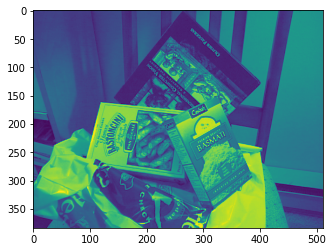

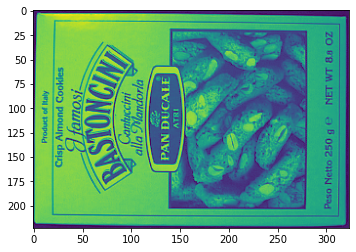

In [ ]:
im3=array(Image.open('box_in_scene.png'))
im4=array(Image.open('box.png'))

imshow(im3)
show()
imshow(im4)
show()

img3=np.array(im3)
img4=np.array(im4)

In [ ]:
ht=Gaus(img4,size=3,sigma=0.01)
un=FAST(ht,t=40)

ht1=ImgD(Gaus(img4,size=3,sigma=0.3))
un1=FAST(ht1,t=40)

ht2=Gaus(img3.copy(),size=3,sigma=0.01)#np.mean(img3,axis=2)
un2=FAST(ht2,t=40)

r=Xarris(ht,un,N=40,si=0.7)
htb=Gaus(ht.copy(),size=5,sigma=1.3)
ang=Ang(ht,r)
discr,coords,rots,dc=BRIEF(htb,r,ang)

r1=Xarris(ht1,un1,N=40,si=0.7)
htb1=Gaus(ht1.copy(),size=5,sigma=1.3)
ang1=Ang(ht1,r1)
discr1,coords1,rots1,dc1=BRIEF(htb1,r1,ang1,coords,rots,False)

r2=Xarris(ht2,un2,N=300,si=0.5)
htb2=Gaus(ht2.copy(),size=5,sigma=1.3)
ang2=Ang(ht2,r2)
discr2,coords2,rots2,dc2=BRIEF(htb2,r2,ang2,coords,rots,False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:431: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:378: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:407: DeprecationWarning: `np.bool` is a deprecated alias for the

206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

BRIEF(imshape:) (223, 324)
31
BRIEF(imshape:) (111, 162)
349
BRIEF(imshape:) (384, 512)


49 / 74 : 0.6621621621621622
75 / 124 : 0.6048387096774194
41 / 72 : 0.5694444444444444
25 / 73 : 0.3424657534246575
22 / 58 : 0.3793103448275862
40 / 83 : 0.4819277108433735
19 / 43 : 0.4418604651162791
53 / 74 : 0.7162162162162162
39 / 86 : 0.45348837209302323
42 / 62 : 0.6774193548387096
46 / 72 : 0.6388888888888888
58 / 92 : 0.6304347826086957
57 / 77 : 0.7402597402597403
53 / 73 : 0.726027397260274
52 / 76 : 0.6842105263157895
octave: 1
Rotation: -0.20943951023931984
Scale: 0.5
Shift: (165;108)


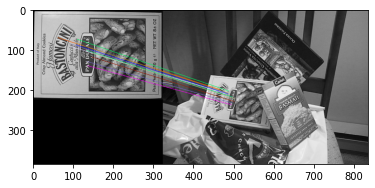

In [ ]:
newimg,CM=CrossChekExp(ht,ht2,[dc,dc1],dc2,[discr,discr1],discr2,[ang,ang1],ang2,rots)

imshow(newimg)
show()